In [1]:
#We will make a basic CNN model to classify CIFAR-10#
#We will use Keras from Tensorflow to build the model#

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.applications import ResNet50

import numpy as np
import matplotlib.pyplot as plt
import datetime
import pandas as pd

#show the tensorflow version
print(tf.__version__)

2.15.0


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7318783589975254995
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14626652160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6758477655843471985
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [24]:
#load the CIFAR-100 dataset & split into train and test sets
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

#Normalize pixel values from 1-255 to 0-1
x_train, x_test = x_train / 255.0, x_test / 255.0

#show the shape of the dataset
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [4]:
import copy
x_train_copy = copy.deepcopy(x_train)

## Cutout Regularization

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2


# Define the cutout function
def cutout(image, mask_size=10):
    h, w, _ = image.shape
    mask = np.ones((h, w), np.float32)

    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Threshold the image to obtain foreground and background regions
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Invert the thresholded image to get the foreground
    foreground = cv2.bitwise_not(thresh)

    # Apply a closing operation to fill holes in the foreground
    kernel = np.ones((5, 5), np.uint8)
    foreground = cv2.morphologyEx(foreground, cv2.MORPH_CLOSE, kernel)

    # Apply dilation to expand the foreground regions slightly
    kernel = np.ones((3, 3), np.uint8)
    foreground = cv2.dilate(foreground, kernel, iterations=1)

    # Apply erosion to shrink the foreground regions slightly
    foreground = cv2.erode(foreground, kernel, iterations=1)

    # Randomly select one background region for cutout
    background_indices = np.argwhere(foreground == 0)
    if len(background_indices) > 0:
        index = np.random.randint(0, len(background_indices))
        y, x = background_indices[index]
        y1 = np.clip(y - mask_size // 2, 0, h)
        y2 = np.clip(y + mask_size // 2, 0, h)
        x1 = np.clip(x - mask_size // 2, 0, w)
        x2 = np.clip(x + mask_size // 2, 0, w)
        mask[y1:y2, x1:x2] = 0

    image = image * np.expand_dims(mask, axis=2)

    return image


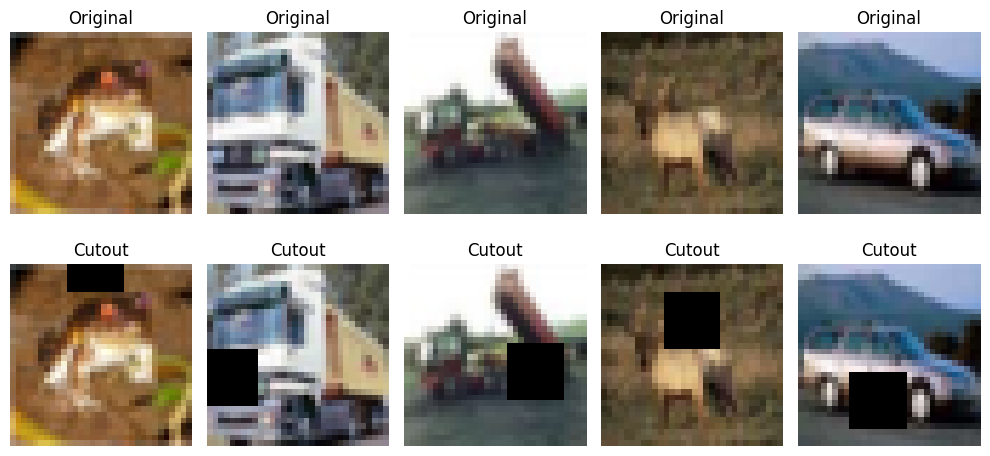

In [4]:
# Load CIFAR-10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
# Apply cutout augmentation to training images
x_train_cutout = np.copy(x_train)
for i in range(len(x_train_cutout)):
    x_train_cutout[i] = cutout(x_train_cutout[i])

# Display original and cutout-augmented images
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[i])
    plt.title("Original")
    plt.axis('off')

    plt.subplot(2, 5, i + 6)
    plt.imshow(x_train_cutout[i])
    plt.title("Cutout")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [5]:
x_train_cutout, x_test = x_train / 255.0, x_test / 255.0

## Random Erasing Regularization

In [ ]:
def random_erasing(image, probability=0.5, sl=0.02, sh=0.2, r1=0.3, mean=[0, 0, 0]):
    if np.random.rand() < probability:
        img_h, img_w, img_c = image.shape
        area = img_h * img_w

        for _ in range(100):
            target_area = np.random.uniform(sl, sh) * area
            aspect_ratio = np.random.uniform(r1, 1 / r1)
            h = int(round(np.sqrt(target_area * aspect_ratio)))
            w = int(round(np.sqrt(target_area / aspect_ratio)))

            if w < img_w and h < img_h:
                x = np.random.randint(0, img_h - h)
                y = np.random.randint(0, img_w - w)
                image[x:x+h, y:y+w, :] = np.random.uniform(0, 1, size=(h, w, img_c))
                break

    return image

In [ ]:
x_train_random_erasing = np.array([random_erasing(image) for image in x_train_copy])

Original images:


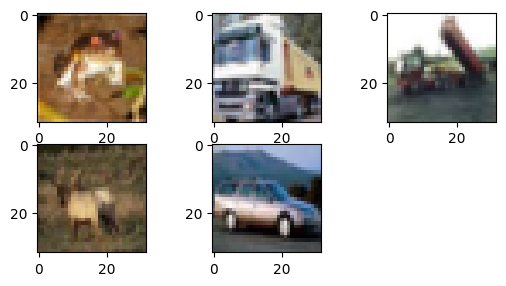

Images with Random Erasing:


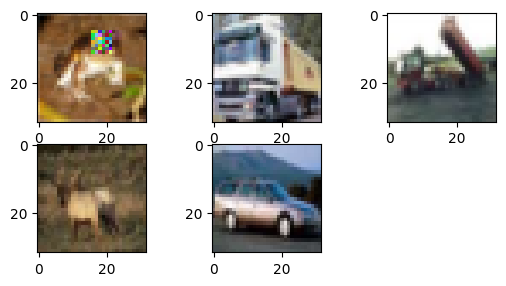

In [ ]:
import matplotlib.pyplot as plt
print("Original images:")
for i in range(5):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i])
plt.show()
print("Images with Random Erasing:")
for i in range(5):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train_random_erasing[i])
plt.show()

## Model

In [6]:
model = Sequential()

# Block 1
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Block 3
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Block 4
model.add(Flatten())
model.add(Dense(256, activation='relu'))

# Block 5
model.add(Dense(10, activation='softmax'))

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 128)         7

### Cutout Model Training

In [7]:
#Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#Train the model
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
history = model.fit(x_train_cutout, y_train, epochs=40, validation_data=(x_test, y_test), callbacks=[tensorboard_callback])
#save loss & validation loss every
train_loss = history.history['loss']
val_loss = history.history['val_loss']


Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1563/1563 [==============================] - 14s 6ms/step - loss: 1.4986 - accuracy: 0.4456 - val_loss: 1.1826 - val_accuracy: 0.5681
Epoch 2/40
1563/1563 [==============================] - 9s 5ms/step - loss: 0.9816 - accuracy: 0.6490 - val_loss: 1.0157 - val_accuracy: 0.6489
Epoch 3/40
1563/1563 [==============================] - 9s 5ms/step - loss: 0.7843 - accuracy: 0.7226 - val_loss: 0.7977 - val_accuracy: 0.7210
Epoch 4/40
1563/1563 [==============================] - 8s 5ms/step - loss: 0.6607 - accuracy: 0.7688 - val_loss: 0.7928 - val_accuracy: 0.7242
Epoch 5/40
1563/1563 [==============================] - 9s 5ms/step - loss: 0.5673 - accuracy: 0.7998 - val_loss: 0.7634 - val_accuracy: 0.7410
Epoch 6/40
1563/1563 [==============================] - 9s 5ms/step - loss: 0.4925 - accuracy: 0.8276 - val_loss: 0.7567 - val_accuracy: 0.7466
Epoch 7/40
1563/1563 [==============================] - 9s 5ms/step - loss: 0.4299 - accuracy: 0.8486 - val_loss: 0.7502 - val_accuracy: 0.7585
Ep

313/313 - 1s - loss: 1.5843 - accuracy: 0.7495 - 661ms/epoch - 2ms/step

Test accuracy 0.7494999766349792
313/313 [==============================] - 1s 2ms/step


<Figure size 1000x1000 with 0 Axes>

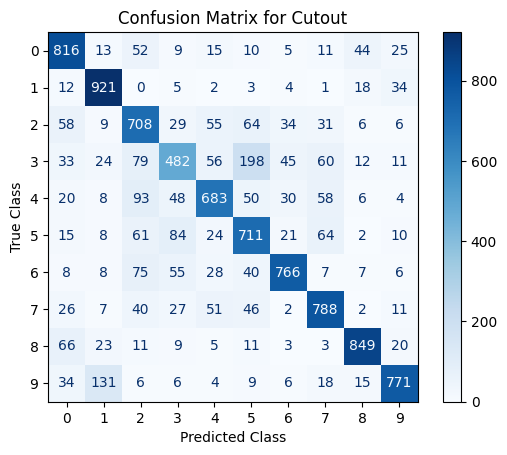

In [8]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print('\nTest accuracy {}'.format(test_acc))
# Prediction
y_pred = model.predict(x_test)

y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = y_test

# Compute the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Display the confusion matrix
plt.figure(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix for Cutout')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

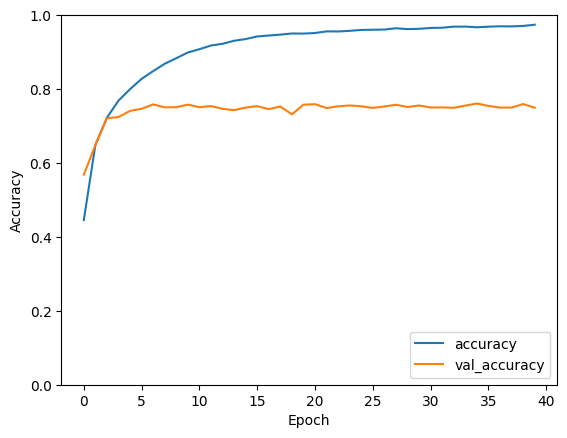

In [9]:
#Plot the training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

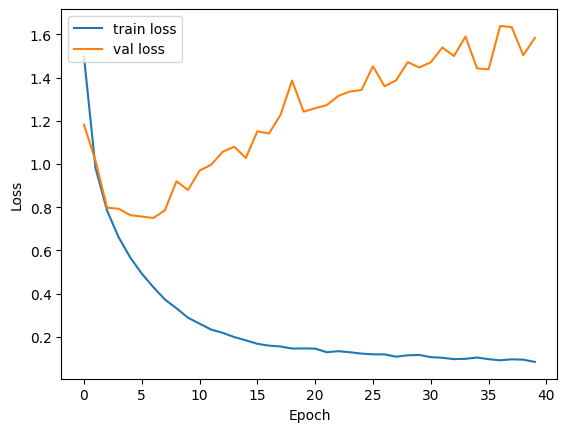

In [10]:
#plot loss
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label = 'val loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
#legend
plt.legend(loc='upper left')
#show plot
plt.show()

In [11]:
#save the trained model (Parameters) so I can use it again without training again
model.save('cifar10_cnn_cutout_obj.h5')
#save the trained model (Weights) so I can use it again without training again
model.save_weights('cifar10_cnn_weights_cutout_obj.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
